In [ ]:
#| default_exp kalman
%load_ext autoreload
%autoreload 2
import jax
jax.config.update("jax_enable_x64", True)

In [ ]:
#| export
import jax.numpy as jnp
import jax.random as jrn
import jax.scipy.linalg as jsla
import tensorflow_probability.substrates.jax.distributions as tfd
from jax import vmap, jit
from jax.lax import scan
from jaxtyping import Array, Float, PRNGKeyArray

from isssm.typing import GLSSM, FilterResult, Observations, SmootherResult
from isssm.util import MVN_degenerate as MVN, vmatmul

In [ ]:
# libraries for this notebook
from isssm.models.stsm import stsm
import jax
import numpy.testing as npt
import matplotlib.pyplot as plt
from isssm.glssm import simulate_glssm
from isssm.typing import GLSSM

# Kalman filter and smoother variants in JAX


Consider a [GLSSM](00_glssm.ipynb) of the form
$$
\begin{align*}
    X_0 &\sim \mathcal N (x_0, \Sigma_0) &\\
    X_{t + 1} &= A_t X_{t} + \varepsilon_{t + 1} &t = 0, \dots, n - 1\\
    \varepsilon_t &\sim \mathcal N (0, \Sigma_t) & t = 1, \dots, n \\
    Y_t &= B_t X_t + \eta_t & t =0, \dots, n & \\
    \eta_t &\sim \mathcal N(0, \Omega_T), & t=0, \dots, n.
\end{align*}
$$



For $t, s \in \{0, \dots, n\}$ consider the following BLPs and associated covariance matrices
$$
\begin{align*}
    \hat X_{t|s} &= \mathbf E \left( X_t | Y_s, \dots, Y_0\right) \\
    \Xi_{t | s} &= \text{Cov} \left(X_t | Y_s, \dots, Y_0 \right)\\
    \hat Y_{t|s} &= \mathbf E \left( Y_t | Y_s, \dots, Y_0\right) \\
    \Psi_{t | s} &= \text{Cov} \left(Y_t | Y_s, \dots, Y_0 \right)
\end{align*}
$$

The Kalman filter consists of the following two-step recursion:

#### Initialization
$$
\begin{align*}
\hat X_{0|0} &= x_0\\
\Xi_{0|0} &= \Sigma_0
\end{align*}
$$

Iterate for $t = 0, \dots, n-1$

#### Prediction
$$
\begin{align*}
    \hat X_{t + 1|t} &= A_t \hat X_{t | t} \\
    \Xi_{t + 1 | t} &= A_t \Xi_{t|t} A_t^T + \Sigma_t\\
\end{align*}
$$

#### Filtering
$$
\begin{align*}
    \hat Y_{t + 1 | t} &= B_t \hat X_{t + 1 | t} \\
    \Psi_{t + 1| t} &= B_{t + 1} \Xi_{t + 1 | t} B_{t + 1}^T + \Omega_{t + 1}\\
    K_t &= \Xi_{t + 1 | t} B_{t + 1}^T \Psi_{t + 1 | t} ^{-1} \\
    \hat X_{t + 1 | t + 1} &= \hat X_{t + 1 | t} + K_t (Y_{t + 1} - \hat Y_{t + 1 | t})\\
    \Xi_{t + 1 | t + 1} &= \Xi_{t + 1 | t} - K_t \Psi_{t + 1| t} K_t^T 
\end{align*}
$$


In [ ]:
#| export


def _predict(
    x_filt: Float[Array, "m"], # $X_{t|t}$
    Xi_filt: Float[Array, "m m"], # $\Xi_{t|t}
    A: Float[Array, "m m"], # $A_t$
    Sigma: Float[Array, "m m"], # $\Sigma_{t + 1}
):
    """perform a single prediction step"""
    x_pred = A @ x_filt
    Xi_pred = A @ Xi_filt @ A.T + Sigma

    return x_pred, Xi_pred


def _filter(
    x_pred: Float[Array, "m"], 
    Xi_pred: Float[Array, "m m"],
    y: Float[Array, "p"],
    B: Float[Array, "p m"],
    Omega: Float[Array, "p p"],
):
    """perform a single filtering step"""
    y_pred = B @ x_pred
    Psi_pred = B @ Xi_pred @ B.T + Omega
    K = Xi_pred @ B.T @ jnp.linalg.pinv(Psi_pred)#jsla.solve(Psi_pred, B).T
    x_filt = x_pred + K @ (y - y_pred)
    Xi_filt = Xi_pred - K @ Psi_pred @ K.T

    return x_filt, Xi_filt


def kalman(
    y: Observations, # observatoins
    glssm: GLSSM, # model
) -> FilterResult: # filtered & predicted states and covariances
    """Perform the Kalman filter"""
    x0, A, Sigma, B, Omega = glssm
    def step(carry, inputs):
        x_filt, Xi_filt = carry
        y, Sigma, Omega, A, B = inputs

        x_pred, Xi_pred = _predict(x_filt, Xi_filt, A, Sigma)
        x_filt_next, Xi_filt_next = _filter(x_pred, Xi_pred, y, B, Omega)

        return (x_filt_next, Xi_filt_next), (x_filt_next, Xi_filt_next, x_pred, Xi_pred)

    # artificial state X_{-1} with mean x_0
    # covariance zero, transition identity
    # will lead to X_0 having correct predictive distribution
    # this avoids having to compute a separate filtering step beforehand

    m, = x0.shape
    A_ext = jnp.concatenate(
        (jnp.eye(m)[jnp.newaxis], A)
    )

    _, (x_filt, Xi_filt, x_pred, Xi_pred) = scan(
        step, (x0, jnp.zeros_like(Sigma[0])), (y, Sigma, Omega, A_ext, B)
    )

    return FilterResult(x_filt, Xi_filt, x_pred, Xi_pred)

Let us check that our implementation works as expected by simulating a single sample from the joint distribution of a [structural time series model](models/10_stsm.ipynb) with seasonality of order 2. 

In [ ]:
glssm_model = stsm(jnp.zeros(4), 0., .1, .1, 100, jnp.eye(4), 3, 2)

key = jrn.PRNGKey(53405234)
key, subkey = jrn.split(key)
(x,), (y,) = simulate_glssm(glssm_model, 1, subkey)

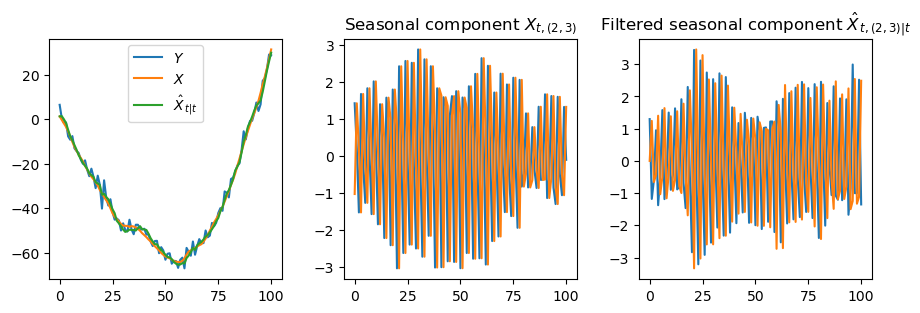

In [ ]:
x_filt, Xi_filt, x_pred, Xi_pred = kalman(y, glssm_model)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(9, 3))
fig.tight_layout()

ax1.set_title("")
ax1.plot(y, label="$Y$")
ax1.plot(x[:,0], label="$X$")
ax1.plot(x_filt[:,0], label="$\\hat X_{{t|t}}$")
ax1.legend()

ax2.plot(x[:,2:])
ax2.set_title("Seasonal component $X_{{t, (2,3)}}$")

ax3.set_title("Filtered seasonal component $\\hat X_{{t, (2,3)|t}}$")
ax3.plot(x_filt[:,2:])

plt.show()


The **Kalman smoother** uses the filter result to obtain $\hat X_{t | n}$ and $\Xi_{t | n}$ for $t = 0, \dots n$.

It is based on the following recursion with initialisation by the filtering result $\hat X_{n | n}$ and $\Xi_{n|n}$ and the (reverse) **gain** $G_t$. 

$$
\begin{align*}
    G_t &= \Xi_{t | t} A_t \Xi_{t + 1 | t} ^{-1}\\
    \hat X_{t | n} &= \hat X_{t | t} + G_t (\hat X_{t + 1| n} - \hat X_{t + 1 | t}) \\
    \Xi_{t | n} &= \Xi_{t | t} - G_t (\Xi_{t + 1 | t} - \Xi_{t + 1 | n}) G_t^T
\end{align*}
$$

In [ ]:
#| export
State = Float[Array, "m"]
StateCov = Float[Array, "m m"]
StateTransition = Float[Array, "m m"]


def _smooth_step(
    x_filt: State,
    x_pred_next: State,
    x_smooth_next: State,
    Xi_filt: StateCov,
    Xi_pred_next: StateCov,
    Xi_smooth_next: StateCov,
    A: StateTransition
):
    err = x_smooth_next - x_pred_next
    Gain = Xi_filt @ A.T @ jnp.linalg.pinv(Xi_pred_next)

    x_smooth = x_filt + Gain @ err
    Xi_smooth = Xi_filt - Gain @ (Xi_pred_next - Xi_smooth_next) @ Gain.T

    return (x_smooth, Xi_smooth)


def smoother(
    filter_result: FilterResult,
    A: Float[Array, "n m m"] # transition matrices
) -> SmootherResult:
    """perform the Kalman smoother"""
    x_filt, Xi_filt, x_pred, Xi_pred = filter_result
    def step(carry, inputs):
        x_smooth_next, Xi_smooth_next = carry
        x_filt, Xi_filt, x_pred_next, Xi_pred_next, A = inputs

        x_smooth, Xi_smooth = _smooth_step(
            x_filt, x_pred_next, x_smooth_next, Xi_filt, Xi_pred_next, Xi_smooth_next,A
        )

        return (x_smooth, Xi_smooth), (x_smooth, Xi_smooth)

    _, (x_smooth, Xi_smooth) = scan(
        step, (x_filt[-1], Xi_filt[-1]), (x_filt[:-1], Xi_filt[:-1], x_pred[1:], Xi_pred[1:], A), reverse=True
    )

    x_smooth = jnp.concatenate([x_smooth, x_filt[None, -1]])
    Xi_smooth = jnp.concatenate([Xi_smooth, Xi_filt[None, -1]])

    return SmootherResult(x_smooth, Xi_smooth)

Let us apply the Kalman smoother to our simulated observations.

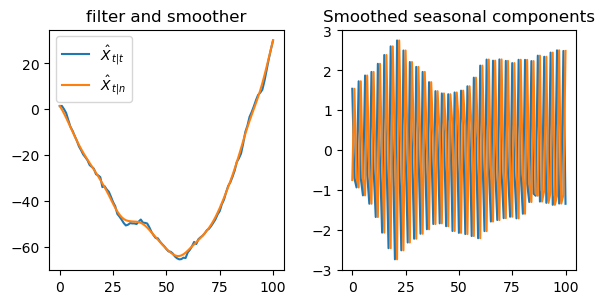

In [ ]:
filtered = kalman(y, glssm_model)

x_smooth, Xi_smooth = smoother(filtered, glssm_model.A)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(6, 3))
fig.tight_layout()
ax1.set_title("filter and smoother")
ax1.plot(x_filt[:,0], label="$\\hat X_{{t | t}} $")
ax1.plot(x_smooth[:,0], label="$\\hat X_{{t | n}}$")
ax1.legend()

ax2.set_title("Smoothed seasonal components")
ax2.plot(x_smooth[:,2:])

plt.show()


The smoothed states are indeed smoother.

## Sampling from the smoothing distribution

After having run the Kalman filter we can use a recursion due to Frühwirth-Schnatter [@Fruhwirth-Schnatter1994Data] to obtain samples from the joint conditional distribution the states given observations.

By the dependency structure of states and observations the conditional densities can be factorized in the following way:

$$
\begin{align*}
p(x_0, \dots, x_n | y_0, \dots, y_n) &=  p(x_n | y_0, \dots, y_n) \prod_{t = n - 1}^0 p(x_{t}| x_{t + 1}, \dots, x_n, y_0, \dots, y_n) \\
&= p(x_n | y_0, \dots, y_n) \prod_{t = n - 1}^0 p(x_{t}| x_{t + 1}, y_0, \dots, y_n)
\end{align*}
$$

and the conditional distributions are again gaussian with conditional expecatation 
$$
\mathbf E (X_{t} | X_{t + 1}, Y_0, \dots, Y_n) = \hat X_{t|t} + G_t (X_{t + 1} - \hat X_{t + 1|t})
$$ and conditional covariance matrix 
$$
\text{Cov} (X_t | X_{t + 1}, Y_0, \dots, Y_n) = \Xi_{t|t} - G_t\Xi_{t + 1 | t} G_t^T
$$

where $G_t = \Xi_{t|t} A_t^T \Xi_{t + 1|t}^{-1}$ is the smoothing gain.

In [ ]:
# | export
def _simulate_smoothed_FW1994(
    x_filt: Float[Array, "n+1 m"],
    Xi_filt: Float[Array, "n+1 m m"],
    Xi_pred: Float[Array, "n+1 m m"],
    A: Float[Array, "n m m"],
    N: int, # number of samples
    key: PRNGKeyArray # the random states
) -> Float[Array, "N n+1 m"]: # array of N samples from the smoothing distribution
    r"""Simulate from smoothing distribution $p(X_0, \dots, X_n|Y_0, \dots, Y_n)$"""

    key, subkey = jrn.split(key)
    X_n = MVN(x_filt[-1], Xi_filt[-1]).sample(N, subkey)

    def sample_backwards(carry, inputs):
        X_smooth_next, key = carry
        x_filt, Xi_filt, Xi_pred, A = inputs

        G = Xi_filt @ jnp.linalg.solve(Xi_pred, A).T

        cond_expectation = x_filt + vmatmul(G, X_smooth_next - (A @ x_filt)[None])
        cond_covariance = Xi_filt - G @ Xi_pred @ G.T

        key, subkey = jrn.split(key)
        new_samples = MVN(cond_expectation, cond_covariance).sample(seed=subkey)
        return (new_samples, key), new_samples

    key, subkey = jrn.split(key)
    _, X = scan(
        sample_backwards,
        (X_n, subkey),
        (x_filt[:-1], Xi_filt[:-1], Xi_pred[1:], A),
        reverse=True,
    )

    X_full = jnp.concatenate((X, X_n[None]))

    return X_full.transpose((1, 0, 2))


def FFBS(
    y: Observations, # Observations $y$
    model: GLSSM, # GLSSM
    N: int, # number of samples 
    key: PRNGKeyArray # random state
) -> Float[Array, "N n+1 m"]: # N samples from the smoothing distribution
    r"""The Forward-Filter Backwards-Sampling Algorithm from [@Fruhwirth-Schnatter1994Data]."""
    x_filt, Xi_filt, _, Xi_pred = kalman(y, model)

    key, subkey = jrn.split(key)
    return _simulate_smoothed_FW1994(x_filt, Xi_filt, Xi_pred, model.A, N, subkey)

In [ ]:
key, subkey = jrn.split(key)
X_sim, = FFBS(y, glssm_model, 1, subkey)

assert X_sim.shape == x.shape

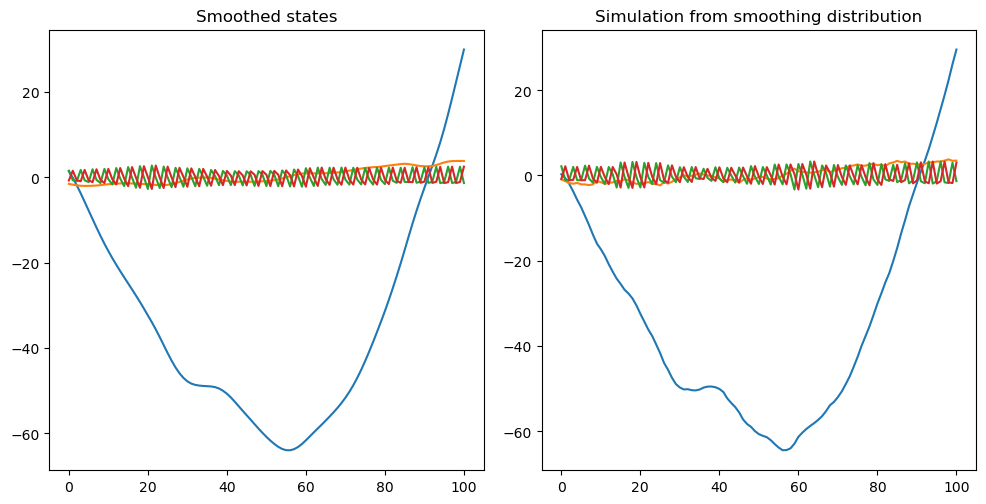

In [ ]:
x_smooth, Xi_smooth = smoother(filtered, glssm_model.A)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 5))
fig.tight_layout()
ax1.set_title("Smoothed states")
ax1.plot(x_smooth)
ax2.set_title("Simulation from smoothing distribution")
ax2.plot(X_sim)
plt.show()

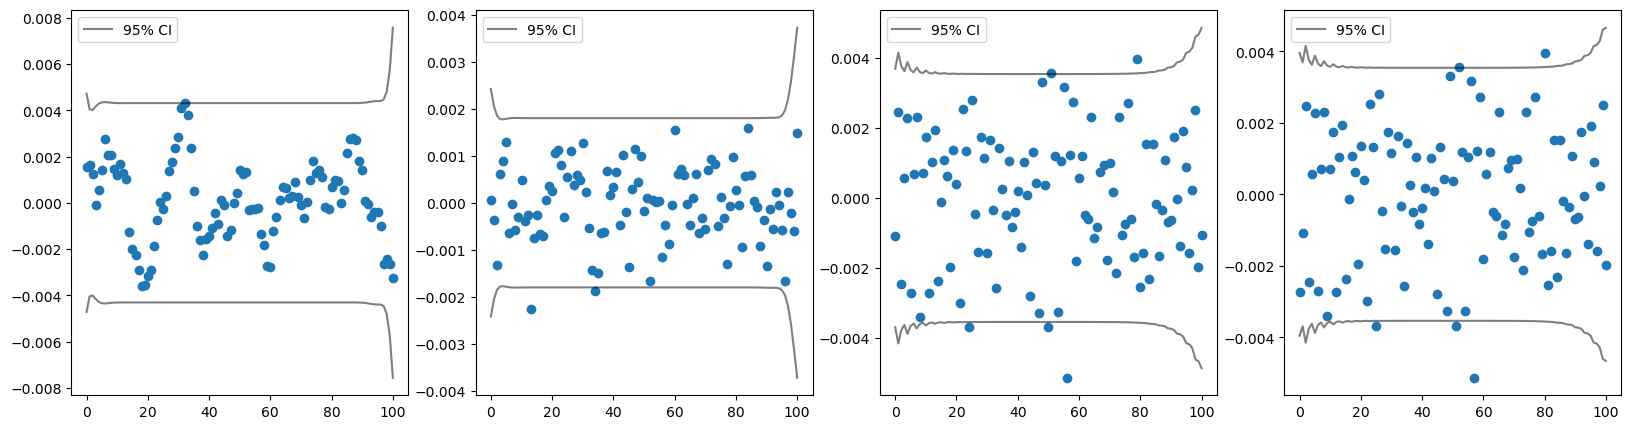

In [ ]:
#| hide
# sanity check: do marginal mean of simulation coincide with Kalman smoother?
key, subkey = jrn.split(key)
N = 1e5
X_sim = _simulate_smoothed_FW1994(x_filt, Xi_filt, Xi_pred, glssm_model.A, N, subkey)

fig, axs = plt.subplots(1, 4, figsize=(20, 5))
np1, p, m = glssm_model.B.shape
for i in range(m):
    smoothed_vars = Xi_smooth[:,i,i]
    ci_bounds = 2 * jnp.sqrt(smoothed_vars) / jnp.sqrt(N)
    axs[i].plot(ci_bounds, color = "black", alpha = .5, label = "95% CI")
    axs[i].plot(-ci_bounds, color = "black", alpha = .5)
    axs[i].scatter(jnp.arange(np1), X_sim[:,:,i].mean(axis = 0) - x_smooth[:,i])
    axs[i].legend()
plt.show()

## The disturbance smoother

When the interest lies in the signal $S_{t} = B_{t}X_{t}$, $t = 0, \dots, n$, it is often more efficient to perform the following disturbance smoother, see Section 4.5 in [@Durbin2012Time] for details.
The recursions run from $t = n$ to $t = 0$ and are initialized by $r_n =0 \in \R^{m}$. While it is also possible to obtain smoothed state innovations $\hat \varepsilon_{t | n}$, we will not be interested in them in the following, so we skip them.

$$
\begin{align*}
    \hat\eta_{t | n} &= \Omega_{t} \left( \Psi_{t| t - 1}^{-1}(Y_{t} - Y_{t | t - 1}) - K_{t}^{T}A_{t}^{T}r_{t} \right) \\
    L_{t} &= A_{t} \left( I - K_{t}B_{t} \right) \\
    r_{t - 1} &= B_{t}^T \Psi_{t | t - 1}\left( Y_{t} - \hat Y_{t| t - 1} \right) + L_{t}^{T}r_{t} 
\end{align*}
$$
While it is also possible to derive smoothed covariance matrices, we will not need them, as we can use [the simulation smoother](#the-simulation-smoother), which is based on mean adjustments.


In [ ]:
# | export

def disturbance_smoother(
    filtered: FilterResult, # filter result
    y: Observations, # observations
    model: GLSSM # model
) -> Float[Array, "n+1 p"]: # smoothed disturbances
    """perform the disturbance smoother for observation disturbances only"""
    x_filt, Xi_filt, x_pred, Xi_pred = filtered
    x0, A, Sigma, B, Omega = model
    np1, p, m = B.shape

    def step(carry, inputs):
        (r,) = carry
        y_tilde, A, B, Omega, Xi_pred = inputs

        Psi_pred = B @ Xi_pred @ B.T + Omega
        Psi_pred_pinv = jnp.linalg.pinv(Psi_pred)
        K = Xi_pred @ B.T @ Psi_pred_pinv

        eta_smooth = Omega @ (Psi_pred_pinv @ y_tilde - K.T @ A.T @ r)
        L = A @ (jnp.eye(m) - K @ B)

        r_prev = B.T @ Psi_pred_pinv @ y_tilde + L.T @ r

        return (r_prev,), (eta_smooth, Psi_pred_pinv, K,L)

    y_tilde = y - vmap(jnp.matmul)(B, x_pred)

    A_ext = jnp.concatenate((A, jnp.eye(m)[jnp.newaxis]), axis=0)
    _, (eta_smooth, Psi_pred_pinv, K, L) = scan(
        step, (jnp.zeros(m),), (y_tilde, A_ext, B, Omega, Xi_pred), reverse=True
    )

    return eta_smooth, (Psi_pred_pinv, K, L)

def smoothed_signals(
    filtered: FilterResult, # filter result
    y: Observations, # observations
    model: GLSSM # model
) -> Float[Array, "n+1 m"]: # smoothed signals
    """compute smoothed signals from filter result"""
    eta_smooth, _ = disturbance_smoother(filtered, y, model)
    return y - eta_smooth

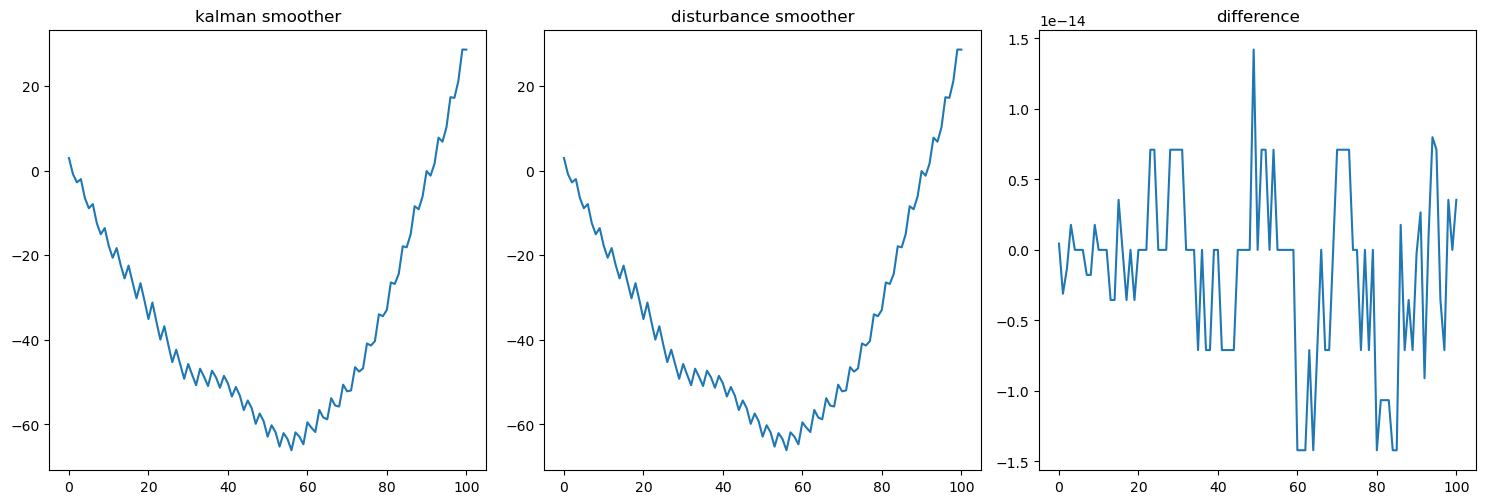

In [ ]:
s_smooth_ks = vmap(jnp.matmul)(glssm_model.B, x_smooth)
s_smooth = smoothed_signals(filtered, y, glssm_model)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15, 5))
fig.tight_layout()
ax1.set_title("kalman smoother")
ax1.plot(s_smooth_ks)
ax2.set_title("disturbance smoother")
ax2.plot(s_smooth)
ax3.set_title("difference")
ax3.plot(s_smooth_ks - s_smooth)
plt.show()

In [ ]:
s_smooth

Array([[  2.94867022],
       [ -0.84736553],
       [ -2.80904471],
       [ -2.03531365],
       [ -6.46991391],
       [ -8.92128714],
       [ -7.93341994],
       [-12.42387253],
       [-15.07516745],
       [-13.61714003],
       [-17.77235628],
       [-20.62674768],
       [-18.34096732],
       [-22.29807935],
       [-25.52197198],
       [-22.48538454],
       [-26.41357051],
       [-30.21646126],
       [-26.63483353],
       [-30.76636258],
       [-35.12023733],
       [-31.21454692],
       [-35.7275934 ],
       [-39.97868918],
       [-36.83058536],
       [-41.21704372],
       [-45.29896787],
       [-42.37428118],
       [-45.8396327 ],
       [-49.25468402],
       [-45.75057405],
       [-48.28639867],
       [-50.77443364],
       [-46.86835413],
       [-48.775589  ],
       [-50.96155104],
       [-47.33248117],
       [-48.89725963],
       [-51.3694248 ],
       [-48.55901998],
       [-50.33081199],
       [-53.44356183],
       [-51.19397317],
       [-53

In [ ]:
vmm = vmap(jnp.matmul)
s_big = 100
big_model = stsm(jnp.zeros(2 + s_big), 0., .1, .1, 100, jnp.eye(2 + s_big), 3, s_big)
key, subkey = jrn.split(key)
_, (big_y,) = simulate_glssm(big_model, 1, subkey)
big_filtered = kalman(y, big_model)

%timeit smoothed_signals(big_filtered, big_y, big_model).block_until_ready()
%timeit vmm(big_model.B, smoother(big_filtered, big_model.A)[0]).block_until_ready()

79.2 ms ± 164 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
534 ms ± 52.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


We see that for large state space, but low dimensional signal, the signal smoother drastically outperforms the simple smoother, if we are interested only in the signals.

## The simulation smoother
The simulation smoother [@Durbin2002Simple] is a method for sampling from the smoothing distribution, without explicitly calculating conditional covariance matrices. It is based on the disturbance smoother. We will implement it for the signal only. 

1. Calculate the conditional expectation $\mathbf E \left( \eta_{t} | Y_{0} = y_{0}, \dots, Y_{n} = y_{n} \right)$ by the disturbance smoother.
2. Generate a new draw $(X^+, Y^+)$ from the state space model using innovations $\eta^+$.
3. Calculate the conditional expectation $\mathbf E \left( \eta^{+} | Y_{0} = y_{0}^+, \dots, Y_{n} = y_{n}^+\right)$ by the disturbance smoother.

Then
$$
\mathbf E \left( \eta_{t} | Y_{0} = y_{0}, \dots, Y_{n} = y_{n} \right)+ \left(\eta^{+} - \mathbf E \left( \eta^{+} | Y_{0} = y_{0}^+, \dots, Y_{n} = y_{n}^+\right)\right) 
$$ 
is a draw from the smoothing distribution $\eta | Y_{0} = y_{0}, \dots, Y_{n} = y_{n}$, because the second term is centered and independent from the first term. The first term contributes the mean, the second term the covariance.

In [ ]:
# | export
from tensorflow_probability.substrates.jax.distributions import Chi2
from isssm.util import degenerate_cholesky

def _sim_from_innovations_disturbances(
    model: GLSSM, eps: Float[Array, "N n+1 m"], eta: Float[Array, "N n+1 p"]
) -> Float[Array, "N n+1 p"]:
    x0, A, Sigma, B, Omega = model
    N, np1, m = eps.shape

    def step(carry, inputs):
        (x,) = carry
        A, B, eps, eta = inputs

        x_next = (A @ x[..., None])[..., 0] + eps
        y_next = (B @ x[..., None])[..., 0] + eta

        return (x_next,), y_next

    A_ext = jnp.concatenate((jnp.eye(m)[None], A), axis=0)
    (x,), y = scan(
        step,
        (jnp.broadcast_to(x0, (N, m)),),
        (A_ext, B, eps.transpose((1, 0, 2)), eta.transpose(1, 0, 2)),
    )

    return y.transpose((1, 0, 2))


def simulation_smoother(
    model: GLSSM,  # model
    y: Observations,  # observations
    N: int,  # number of samples to draw
    key: PRNGKeyArray,  # random number seed
    antithetics: bool= True # whether to use location and scale antithetics
) -> Float[Array, "N n+1 m"]:  # N samples from the smoothing distribution of signals
    """Simulate from the smoothing distribution of signals"""
    np1, p, m = model.B.shape

    @jit
    def signal_filter_smoother(y, model):
        return smoothed_signals(kalman(y, model), y, model)

    key, subkey = jrn.split(key)
    u_eps = MVN(jnp.zeros((np1, m)), jnp.eye(m)[None]).sample(N, subkey)
    chol_Sigma = degenerate_cholesky(model.Sigma)
    eps = vmap(vmap(jnp.matmul), (None, 0))(chol_Sigma, u_eps)

    key, subkey = jrn.split(key)
    u_eta = MVN(jnp.zeros((np1, p)), jnp.eye(p)[None]).sample(N, subkey)
    chol_Omega = degenerate_cholesky(model.Omega)
    eta = vmap(vmap(jnp.matmul), (None, 0))(chol_Omega, u_eta)

    y_sim = _sim_from_innovations_disturbances(model, eps, eta)

    signals_smooth = signal_filter_smoother(y, model)
    sim_signals = y_sim - eta
    sim_signals_smooth = vmap(signal_filter_smoother, (0, None))(y_sim, model)

    samples = signals_smooth[None] + (sim_signals - sim_signals_smooth)
    location_antithetics = signals_smooth[None] - (sim_signals - sim_signals_smooth)

    
    # todo: rescale eps, eta
    c = jnp.linalg.norm(jnp.concatenate((u_eps, u_eta), axis=-1), axis=(1,2)) ** 2
    # ensure dtype is Float64
    chi_dist = Chi2(np1 * (m + p) * jnp.ones(1))    
    c_prime = chi_dist.quantile(1.0 - chi_dist.cdf(c))

    scale_antithetics = signals_smooth[None] + jnp.sqrt(c_prime / c)[:,None,None] * (sim_signals - sim_signals_smooth)
    loc_scale_antithetics = signals_smooth[None] - jnp.sqrt(c_prime / c)[:,None,None] * (sim_signals - sim_signals_smooth)

    full_samples = jnp.concatenate((samples, location_antithetics, scale_antithetics, loc_scale_antithetics), axis=0)

    return full_samples

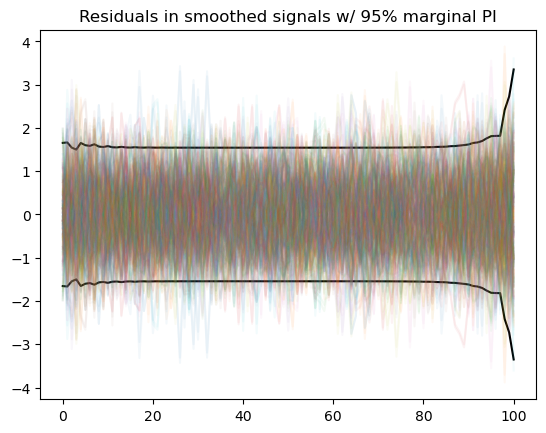

In [ ]:
smooth_signals_sim = simulation_smoother(glssm_model, y, 100, subkey)

signal_vars = vmap(lambda B, Xi: B@ Xi @ B.T)(glssm_model.B, Xi_smooth)[:,0,0]
plt.plot(2 * signal_vars, color = "black", label = "95% PI")
plt.title("Residuals in smoothed signals w/ 95% marginal PI")
plt.plot(-2 * signal_vars, color = "black")
plt.plot(smooth_signals_sim[:,:,0].T - s_smooth, alpha = .05)
plt.show()

In [ ]:
vmm = vmap(vmap(jnp.matmul), (None, 0))
s_big = 300
big_model = stsm(jnp.zeros(2 + s_big), 0., .1, .1, 100, jnp.eye(2 + s_big), 3, s_big)
key, subkey = jrn.split(key)
_, (big_y,) = simulate_glssm(big_model, 1, subkey)
N = 100
key, subkey = jrn.split(key)

# ignore antithetics, could also be used for FFBS
%timeit simulation_smoother(big_model, big_y, N, subkey).block_until_ready()
%timeit vmm(big_model.B, FFBS(big_y, big_model, N, subkey)).block_until_ready()

2.26 s ± 67.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
3.54 s ± 52.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()